# Classifying ALL with Neural Network using Optuna

In this notebook we were using [SciKeras](https://pypi.org/project/scikeras/#description), a Scikit-Learn API wrapper for Keras.

First we atarted with base models:
- KerasClassifier only
- pipeline with MinMaxScaler, PCA and KerasClassifier  

In the rest of the notebook we used Optuna to tune hyperparameters in the pipeline. We also tried feature selection with ANOVA, but with no success.

We used PCA with a fixed number of components (N_components=1000) and with `n_components` as a parameter in Optuna optimization process.

Macro averaged f1_score was used as the metrics to find the best Optuna's trial.

At the very end of the notebook, four best models are displayed.

The best model is nn_pca_3 with confusion matrix:

[[ 263    76]  
 [ 159 1296]]
 
 **NOTE:**
 
 - SciKeras 10.0.0 requires Python <3.11
 - Due to some problems with GPU, I had to downgrade TensorFlow to 2.10
 - This version of SciKeras requires slightly different procedure to save/load pipelined models. Check this in the chapter *The Best Models*.
 

## Dependencies

In [262]:
import os
import pandas as pd
import numpy as np
# To remove these warnings : "Your kernel may have been built without NUMA support."
#   run these 2 lines before importing tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'        # or any {'0', '1', '2', '3'}

import tensorflow as tf 
random_state = 10
np.random.seed(random_state)
tf.random.set_seed(random_state)

import joblib

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
### sns.set_style('darkgrid')

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.pipeline import make_pipeline, Pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Keras
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier

# Import Optuna
import optuna

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the script from different folder
import sys  
#  sys.path.append('/content/drive/MyDrive/Omdena/Team1/scripts')
sys.path.append('../scripts')

import metrics_utilities as mu

## Batch_4 Train Dataset

In [3]:
# df_train = pd.read_pickle('/content/drive/MyDrive/Omdena/Team1/batch_4/train_data.pickle')
df_train = pd.read_pickle('../data/batch_4/train_data.pickle')
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.185833,0.0,0.00000,0.000000,0.0,0.0,0.0,0.231458,0.0,0.0,...,0.545079,0.170755,0.0,0.096298,0.174819,0.0,0.0,0.361853,0.0,0
1,0.123157,0.0,0.56544,0.350086,0.0,0.0,0.0,0.228849,0.0,0.0,...,0.663390,0.115025,0.0,0.099379,0.516193,0.0,0.0,0.239392,0.0,1
2,0.197977,0.0,0.00000,0.000000,0.0,0.0,0.0,0.155163,0.0,0.0,...,0.663023,0.021846,0.0,0.000000,0.173690,0.0,0.0,0.270634,0.0,1
3,0.580151,0.0,0.00000,0.000000,0.0,0.0,0.0,0.298566,0.0,0.0,...,0.470815,0.000000,0.0,0.000000,0.118325,0.0,0.0,0.000000,0.0,0
4,0.066450,0.0,0.00000,0.000000,0.0,0.0,0.0,0.145156,0.0,0.0,...,0.645798,0.015262,0.0,0.027536,0.275665,0.0,0.0,0.000000,0.0,0


#### Separate features and labels

In [4]:
X_train = df_train.iloc[:, : -1]
y_train = df_train['label']
print(X_train.shape, y_train.shape)

(11917, 4608) (11917,)


## Batch_4 Test Dataset

In [5]:
# df_test = pd.read_pickle('/content/drive/MyDrive/Omdena/Team1/batch_4/test_data.pickle')
df_test = pd.read_pickle('../data/batch_4/test_data.pickle')
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.141500,0.0,0.000000,0.000000,0.0,0.0,0.0,0.151137,0.0,0.0,...,0.885778,0.066009,0.0,0.169458,0.570154,0.0,0.0,0.090579,0.0,0
1,0.047403,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.649062,0.260996,0.0,0.049776,0.494771,0.0,0.0,0.480568,0.0,0
2,0.000000,0.0,0.000000,0.023559,0.0,0.0,0.0,0.060329,0.0,0.0,...,0.725523,0.166289,0.0,0.131945,0.299330,0.0,0.0,0.000000,0.0,0
3,0.002286,0.0,0.655825,0.259398,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.626934,0.244303,0.0,0.100791,0.448022,0.0,0.0,0.295682,0.0,0
4,0.279953,0.0,0.000000,0.000000,0.0,0.0,0.0,0.168589,0.0,0.0,...,0.489483,0.166786,0.0,0.000000,0.212874,0.0,0.0,0.000000,0.0,0


#### Separate features and labels

In [6]:
X_test = df_test.iloc[:, :-1]
y_test = df_test['label']
print(X_test.shape, y_test.shape)

(1794, 4608) (1794,)


#### Names of Classes

In [7]:
target_names = ['hem', 'all']

## Implement the Scikit-Learn classifier interface.

In [8]:
# Import model build function "get_clf"from the script "keras_model.py"
import keras_model as km

In [17]:
clf = KerasClassifier(
    model=km.get_clf,
    loss="binary_crossentropy",
    hidden_layer_sizes=(10, 10,10),
    dropout=0.5,
    batch_size=64,
    optimizer='adam',
    optimizer__learning_rate=0.00001,
    epochs=50,
    verbose=1,
    random_state=random_state,  
)

In [18]:
clf.fit(X_train, y_train)

Epoch 1/50
187/187 [==============================] - 2s 9ms/step - loss: 0.6707
Epoch 2/50
187/187 [==============================] - 2s 10ms/step - loss: 0.6519
Epoch 3/50
187/187 [==============================] - 2s 9ms/step - loss: 0.6442
Epoch 4/50
187/187 [==============================] - 2s 9ms/step - loss: 0.6396
Epoch 5/50
187/187 [==============================] - 2s 9ms/step - loss: 0.6373
Epoch 6/50
187/187 [==============================] - 2s 9ms/step - loss: 0.6337
Epoch 7/50
187/187 [==============================] - 2s 10ms/step - loss: 0.6292
Epoch 8/50
187/187 [==============================] - 2s 9ms/step - loss: 0.6232
Epoch 9/50
187/187 [==============================] - 2s 10ms/step - loss: 0.6237
Epoch 10/50
187/187 [==============================] - 2s 10ms/step - loss: 0.6235
Epoch 11/50
187/187 [==============================] - 2s 10ms/step - loss: 0.6205
Epoch 12/50
187/187 [==============================] - 2s 9ms/step - loss: 0.6189
Epoch 13/50
187/187 

KerasClassifier(
	model=<function get_clf at 0x7fef62614430>
	build_fn=None
	warm_start=False
	random_state=10
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	hidden_layer_sizes=(10, 10, 10)
	dropout=0.5
	optimizer__learning_rate=1e-05
	class_weight=None
)

In [19]:
y_pred = clf.predict(X_test)

29/29 [==============================] - 0s 3ms/step


In [20]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 84.34


In [21]:
# Compare training and testing scores
print(f"Training Data Score: {clf.score(X_train, y_train)}")
print(f"Testing Data Score: {clf.score(X_test, y_test)}")

187/187 [==============================] - 1s 3ms/step
Training Data Score: 0.8707728455148108
29/29 [==============================] - 0s 3ms/step
Testing Data Score: 0.8433667781493869


In [22]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 178  161]
 [ 120 1335]]


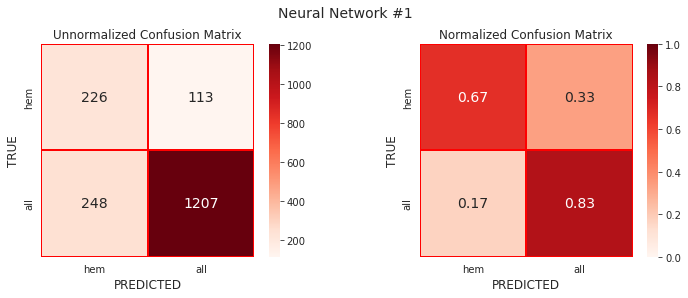

In [72]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network #1', y_test, y_pred, target_names, 'Reds')

In [18]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.91      0.21      0.34       339
         all       0.84      1.00      0.91      1455

    accuracy                           0.85      1794
   macro avg       0.88      0.60      0.63      1794
weighted avg       0.86      0.85      0.81      1794



## Pipeline with scaler, PCA and classifier

In [57]:
clf = KerasClassifier(
    model=km.get_clf,
    loss="binary_crossentropy",
    hidden_layer_sizes=(10, 10,10),
    dropout=0.5,
    batch_size=64,
    optimizer='adam',
    optimizer__learning_rate=0.0001,
    epochs=100,
    verbose=1,
    random_state=random_state,  
)

In [66]:
# Define model with pipeline
pipe = Pipeline(
    steps = (
        ('scaler', MinMaxScaler()),
        #('pca', PCA(num_pca_components)),
        ('clf', clf)
    )
)

In [67]:
pipe.fit(X_train, y_train)

Epoch 1/100
187/187 [==============================] - 2s 10ms/step - loss: 0.6936
Epoch 2/100
187/187 [==============================] - 2s 9ms/step - loss: 0.6931
Epoch 3/100
187/187 [==============================] - 2s 10ms/step - loss: 0.6931
Epoch 4/100
187/187 [==============================] - 2s 9ms/step - loss: 0.6930
Epoch 5/100
187/187 [==============================] - 2s 9ms/step - loss: 0.6931
Epoch 6/100
187/187 [==============================] - 2s 9ms/step - loss: 0.6930
Epoch 7/100
187/187 [==============================] - 2s 9ms/step - loss: 0.6929
Epoch 8/100
187/187 [==============================] - 2s 10ms/step - loss: 0.6929
Epoch 9/100
187/187 [==============================] - 2s 9ms/step - loss: 0.6930
Epoch 10/100
187/187 [==============================] - 2s 10ms/step - loss: 0.6930
Epoch 11/100
187/187 [==============================] - 2s 10ms/step - loss: 0.6929
Epoch 12/100
187/187 [==============================] - 2s 9ms/step - loss: 0.6929
Epoch 13

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf',
                 KerasClassifier(batch_size=64, dropout=0.5, epochs=100, hidden_layer_sizes=(10, 10, 10), loss='binary_crossentropy', model=<function get_clf at 0x7fef62614430>, optimizer='adam', optimizer__learning_rate=0.0001, random_state=10))])

In [60]:
y_pred = pipe.predict(X_test)

29/29 [==============================] - 0s 3ms/step


In [61]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 83.50


In [62]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

187/187 [==============================] - 0s 2ms/step
Training Data Score: 0.9624905597046236
29/29 [==============================] - 0s 3ms/step
Testing Data Score: 0.835005574136009


In [63]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 238  101]
 [ 195 1260]]


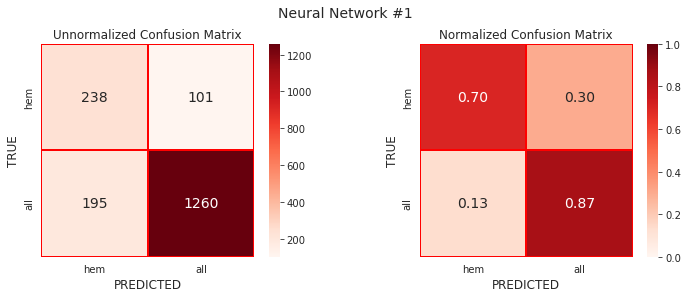

In [64]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network #1', y_test, y_pred, target_names, 'Reds')

In [65]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.55      0.70      0.62       339
         all       0.93      0.87      0.89      1455

    accuracy                           0.84      1794
   macro avg       0.74      0.78      0.76      1794
weighted avg       0.85      0.84      0.84      1794



# Hyperparameter Tuning

In [99]:
clf = KerasClassifier(
    model=km.get_clf,
    loss="binary_crossentropy",
    model__hidden_layer_sizes=(10, 10),
    model__dropout=0.5,
    batch_size=64,
    optimizer='adam',
    optimizer__learning_rate=0.0001,
    epochs=100,
    verbose=0,
    random_state=random_state,  
)

## PCA - 1000

In [232]:
# Define model with pipeline
num_pca_components = 1000
pipe = Pipeline(
    steps = (
        ('scaler', MinMaxScaler()),
        ('pca', PCA(num_pca_components)),
        ('clf', clf)
    )
)

## Optuna Objective Function

In [233]:
def objective(trial):
    """Define the objective function"""

    n_layers = trial.suggest_int('n_layers', 1, 2) # no. of hidden layers 
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f"n_units_{i+1}", 20, 300, 20)) # no. of hidden unit
    
    params = {
        'clf__epochs' : trial.suggest_int('clf__epochs', 10, 150, 10),
        'clf__batch_size' : trial.suggest_categorical('clf__batch_size', [32, 64, 128]),
        'clf__model__dropout' : trial.suggest_float('clf__model__dropout', 0.2, 0.6, step=0.1),
         ###'clf__model__hidden_layer_sizes' : [(100, ), (50, 50, )],
        'clf__optimizer__learning_rate' : trial.suggest_float('clf__optimizer__learning_rate', 1e-5, 1e-1, log=True),
    }
    
    params['clf__model__hidden_layer_sizes'] = tuple(layers)

    pipe.set_params(**params)
   
    # Fit the model
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [234]:
study = optuna.create_study(direction='maximize')

[I 2023-05-02 13:40:38,327] A new study created in memory with name: no-name-f117fa98-5d2c-4096-a41c-5b2075b2c3e0


## Optimize the Objective Function

In [235]:
study.optimize(objective, n_trials=20)

[I 2023-05-02 13:41:57,460] Trial 0 finished with value: 0.7699587517934003 and parameters: {'n_layers': 2, 'n_units_1': 160, 'n_units_2': 260, 'clf__epochs': 130, 'clf__batch_size': 128, 'clf__model__dropout': 0.30000000000000004, 'clf__optimizer__learning_rate': 1.107038964952444e-05}. Best is trial 0 with value: 0.7699587517934003.
[I 2023-05-02 13:46:06,612] Trial 1 finished with value: 0.7764894891293646 and parameters: {'n_layers': 1, 'n_units_1': 200, 'clf__epochs': 120, 'clf__batch_size': 32, 'clf__model__dropout': 0.30000000000000004, 'clf__optimizer__learning_rate': 0.0013021012077270313}. Best is trial 1 with value: 0.7764894891293646.
[I 2023-05-02 13:48:31,535] Trial 2 finished with value: 0.1589310829817159 and parameters: {'n_layers': 2, 'n_units_1': 280, 'n_units_2': 160, 'clf__epochs': 40, 'clf__batch_size': 64, 'clf__model__dropout': 0.6, 'clf__optimizer__learning_rate': 0.05269195953407697}. Best is trial 1 with value: 0.7764894891293646.
[I 2023-05-02 13:51:33,838] 

In [255]:
study.optimize(objective, n_trials=20)

[I 2023-05-02 15:24:13,169] Trial 20 finished with value: 0.7741751957535412 and parameters: {'n_layers': 2, 'n_units_1': 140, 'n_units_2': 200, 'clf__epochs': 80, 'clf__batch_size': 128, 'clf__model__dropout': 0.2, 'clf__optimizer__learning_rate': 8.227330700980922e-05}. Best is trial 18 with value: 0.7949774963973747.
[I 2023-05-02 15:25:13,474] Trial 21 finished with value: 0.7861205330740119 and parameters: {'n_layers': 2, 'n_units_1': 60, 'n_units_2': 200, 'clf__epochs': 90, 'clf__batch_size': 128, 'clf__model__dropout': 0.30000000000000004, 'clf__optimizer__learning_rate': 0.000269158721551291}. Best is trial 18 with value: 0.7949774963973747.
[I 2023-05-02 15:26:24,238] Trial 22 finished with value: 0.7792168593526829 and parameters: {'n_layers': 2, 'n_units_1': 60, 'n_units_2': 200, 'clf__epochs': 90, 'clf__batch_size': 128, 'clf__model__dropout': 0.30000000000000004, 'clf__optimizer__learning_rate': 0.00015441934264914028}. Best is trial 18 with value: 0.7949774963973747.
[I 2

In [269]:
study.optimize(objective, n_trials=20)

[I 2023-05-02 15:54:05,937] Trial 40 finished with value: 0.7794205794205795 and parameters: {'n_layers': 2, 'n_units_1': 80, 'n_units_2': 220, 'clf__epochs': 80, 'clf__batch_size': 32, 'clf__model__dropout': 0.30000000000000004, 'clf__optimizer__learning_rate': 0.002031131873317851}. Best is trial 25 with value: 0.8003149201452489.
[I 2023-05-02 15:55:09,509] Trial 41 finished with value: 0.7786215971016408 and parameters: {'n_layers': 2, 'n_units_1': 40, 'n_units_2': 300, 'clf__epochs': 30, 'clf__batch_size': 32, 'clf__model__dropout': 0.2, 'clf__optimizer__learning_rate': 0.0006882900411043679}. Best is trial 25 with value: 0.8003149201452489.
[I 2023-05-02 15:56:09,532] Trial 42 finished with value: 0.787091895313236 and parameters: {'n_layers': 2, 'n_units_1': 20, 'n_units_2': 260, 'clf__epochs': 20, 'clf__batch_size': 32, 'clf__model__dropout': 0.2, 'clf__optimizer__learning_rate': 0.0008677591548066226}. Best is trial 25 with value: 0.8003149201452489.
[I 2023-05-02 15:57:26,028

## Best Parameters

In [270]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 60
Best trial:
  Value: 0.8003149201452489
  Params: 
    n_layers: 2
    n_units_1: 40
    n_units_2: 240
    clf__epochs: 100
    clf__batch_size: 128
    clf__model__dropout: 0.4
    clf__optimizer__learning_rate: 0.0005366554542437141


## Re-fit the model

In [257]:
params_t = trial.params
params_t

{'n_layers': 2,
 'n_units_1': 40,
 'n_units_2': 240,
 'clf__epochs': 100,
 'clf__batch_size': 128,
 'clf__model__dropout': 0.4,
 'clf__optimizer__learning_rate': 0.0005366554542437141}

In [258]:
### params = {k:v for k,v in params_t.items() if k.startswith('clf')}
params = {k:v for k,v in params_t.items() if '__' in k}
params

{'clf__epochs': 100,
 'clf__batch_size': 128,
 'clf__model__dropout': 0.4,
 'clf__optimizer__learning_rate': 0.0005366554542437141}

In [259]:
if 'n_units_2' in params_t:
    params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'], params_t['n_units_2'])
else:
    params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'],)
    
params

{'clf__epochs': 100,
 'clf__batch_size': 128,
 'clf__model__dropout': 0.4,
 'clf__optimizer__learning_rate': 0.0005366554542437141,
 'clf__model__hidden_layer_sizes': (40, 240)}

In [260]:
pipe.set_params(**params)
    ## model = SVC(**params, kernel='linear', random_state=random_state)
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=1000)),
                ('clf',
                 KerasClassifier(batch_size=128, epochs=100, loss='binary_crossentropy', model=<function get_clf at 0x7fef62614430>, model__dropout=0.4, model__hidden_layer_sizes=(40, 240), optimizer='adam', optimizer__learning_rate=0.0005366554542437141, random_state=10, verbose=0))])

In [268]:
# Save the model
# joblib.dump(mlp, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/nn_pca_1.pkl')
joblib.dump(pipe, './saved_models/batch_4_stack/nn_pca_2.pkl')

INFO:tensorflow:Assets written to: ram://8ca6c01392f44b7f818015b5d5264584/assets


['./saved_models/batch_4_stack/nn_pca_2.pkl']

In [261]:
pipe['clf'].model_.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_226 (Dense)           (None, 1000)              1001000   
                                                                 
 dense_227 (Dense)           (None, 40)                40040     
                                                                 
 dropout_104 (Dropout)       (None, 40)                0         
                                                                 
 dense_228 (Dense)           (None, 240)               9840      
                                                                 
 dropout_105 (Dropout)       (None, 240)               0         
                                                                 
 dense_229 (Dense)           (None, 1)                 241       
                                                                 
Total params: 1,051,121
Trainable params: 1,051,121
N

In [262]:
y_pred = pipe.predict(X_test)

In [263]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 85.45


In [264]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8545150501672241


In [265]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 258   81]
 [ 180 1275]]


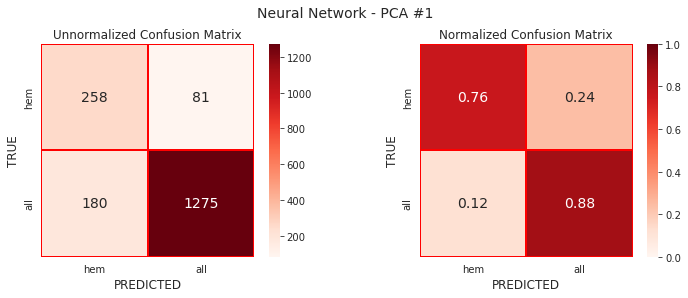

In [266]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network - PCA #1', y_test, y_pred, target_names, 'Reds')

In [267]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.59      0.76      0.66       339
         all       0.94      0.88      0.91      1455

    accuracy                           0.85      1794
   macro avg       0.76      0.82      0.79      1794
weighted avg       0.87      0.85      0.86      1794



## PCA - Tuned

In [11]:
# Define model with pipeline
num_pca_components = 1000
pipe = Pipeline(
    steps = (
        ('scaler', MinMaxScaler()),
        ('pca', PCA(num_pca_components)),
        ('clf', clf)
    )
)

## Optuna Objective Function

In [12]:
def objective(trial):
    """Define the objective function"""

    n_layers = trial.suggest_int('n_layers', 1, 2) # no. of hidden layers 
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f"n_units_{i+1}", 20, 300, 20)) # no. of hidden unit
    
    params = {
        'pca__n_components' : trial.suggest_int('pca__n_components', 500, 3500, 100),
        'clf__epochs' : trial.suggest_int('clf__epochs', 10, 150, 10),
        'clf__batch_size' : trial.suggest_categorical('clf__batch_size', [32, 64, 128]),
        ### 'clf__model__dropout' : trial.suggest_float('clf__model__dropout', 0.2, 0.6, step=0.1),
        'clf__model__dropout' : trial.suggest_float('clf__model__dropout', 0.2, 0.6),
         ###'clf__model__hidden_layer_sizes' : [(100, ), (50, 50, )],
        'clf__optimizer__learning_rate' : trial.suggest_float('clf__optimizer__learning_rate', 1e-5, 1e-1, log=True),
    }
    
    params['clf__model__hidden_layer_sizes'] = tuple(layers)

    pipe.set_params(**params)
   
    # Fit the model
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [13]:
study = optuna.create_study(direction='maximize')

[I 2023-05-02 17:10:23,920] A new study created in memory with name: no-name-eac5af57-65b6-452e-b963-4a4de259d1f1


## Optimize the Objective Function

In [14]:
study.optimize(objective, n_trials=20)

[I 2023-05-02 17:11:41,019] Trial 0 finished with value: 0.7829154978962132 and parameters: {'n_layers': 1, 'n_units_1': 140, 'pca__n_components': 700, 'clf__epochs': 70, 'clf__batch_size': 64, 'clf__model__dropout': 0.6, 'clf__optimizer__learning_rate': 0.001339495162641897}. Best is trial 0 with value: 0.7829154978962132.
[I 2023-05-02 17:13:26,082] Trial 1 finished with value: 0.7718705687546313 and parameters: {'n_layers': 1, 'n_units_1': 180, 'pca__n_components': 800, 'clf__epochs': 60, 'clf__batch_size': 32, 'clf__model__dropout': 0.5, 'clf__optimizer__learning_rate': 0.00015691863192345565}. Best is trial 0 with value: 0.7829154978962132.
[I 2023-05-02 17:14:39,325] Trial 2 finished with value: 0.7681483983072752 and parameters: {'n_layers': 1, 'n_units_1': 20, 'pca__n_components': 1300, 'clf__epochs': 70, 'clf__batch_size': 64, 'clf__model__dropout': 0.2, 'clf__optimizer__learning_rate': 1.2729639697857197e-05}. Best is trial 0 with value: 0.7829154978962132.
[I 2023-05-02 17:1

In [27]:
study.optimize(objective, n_trials=20)

[I 2023-05-02 18:26:15,758] Trial 20 finished with value: 0.7633919666270375 and parameters: {'n_layers': 2, 'n_units_1': 220, 'n_units_2': 160, 'pca__n_components': 1500, 'clf__epochs': 30, 'clf__batch_size': 64, 'clf__model__dropout': 0.30000000000000004, 'clf__optimizer__learning_rate': 0.0009997940554358807}. Best is trial 0 with value: 0.7829154978962132.
[I 2023-05-02 18:26:43,343] Trial 21 finished with value: 0.7833937653614971 and parameters: {'n_layers': 2, 'n_units_1': 140, 'n_units_2': 280, 'pca__n_components': 900, 'clf__epochs': 30, 'clf__batch_size': 128, 'clf__model__dropout': 0.4, 'clf__optimizer__learning_rate': 0.0016812453072319437}. Best is trial 21 with value: 0.7833937653614971.
[I 2023-05-02 18:27:23,392] Trial 22 finished with value: 0.7682999523128278 and parameters: {'n_layers': 2, 'n_units_1': 160, 'n_units_2': 220, 'pca__n_components': 700, 'clf__epochs': 50, 'clf__batch_size': 128, 'clf__model__dropout': 0.4, 'clf__optimizer__learning_rate': 0.002345956422

In [40]:
study.optimize(objective, n_trials=20)

[I 2023-05-02 19:06:51,130] Trial 40 finished with value: 0.7577908510885737 and parameters: {'n_layers': 1, 'n_units_1': 160, 'pca__n_components': 600, 'clf__epochs': 30, 'clf__batch_size': 32, 'clf__model__dropout': 0.4, 'clf__optimizer__learning_rate': 0.0028840971073470696}. Best is trial 31 with value: 0.7958702287733678.
[I 2023-05-02 19:07:38,708] Trial 41 finished with value: 0.7547426111398463 and parameters: {'n_layers': 1, 'n_units_1': 180, 'pca__n_components': 1400, 'clf__epochs': 20, 'clf__batch_size': 64, 'clf__model__dropout': 0.6, 'clf__optimizer__learning_rate': 0.001255548403770742}. Best is trial 31 with value: 0.7958702287733678.
[I 2023-05-02 19:08:32,243] Trial 42 finished with value: 0.7765739351423142 and parameters: {'n_layers': 1, 'n_units_1': 100, 'pca__n_components': 1600, 'clf__epochs': 30, 'clf__batch_size': 64, 'clf__model__dropout': 0.6, 'clf__optimizer__learning_rate': 0.0003178345344612528}. Best is trial 31 with value: 0.7958702287733678.
[I 2023-05-0

## Best Parameters

In [41]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 60
Best trial:
  Value: 0.7958702287733678
  Params: 
    n_layers: 1
    n_units_1: 120
    pca__n_components: 1400
    clf__epochs: 40
    clf__batch_size: 32
    clf__model__dropout: 0.6
    clf__optimizer__learning_rate: 0.0009184685330138193


## Re-fit the model

In [29]:
params_t = trial.params
params_t

{'n_layers': 1,
 'n_units_1': 120,
 'pca__n_components': 1400,
 'clf__epochs': 40,
 'clf__batch_size': 32,
 'clf__model__dropout': 0.6,
 'clf__optimizer__learning_rate': 0.0009184685330138193}

In [30]:
### params = {k:v for k,v in params_t.items() if k.startswith('clf')}
params = {k:v for k,v in params_t.items() if '__' in k}
params

{'pca__n_components': 1400,
 'clf__epochs': 40,
 'clf__batch_size': 32,
 'clf__model__dropout': 0.6,
 'clf__optimizer__learning_rate': 0.0009184685330138193}

In [31]:
if 'n_units_2' in params_t:
    params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'], params_t['n_units_2'])
else:
    params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'],)
    
params

{'pca__n_components': 1400,
 'clf__epochs': 40,
 'clf__batch_size': 32,
 'clf__model__dropout': 0.6,
 'clf__optimizer__learning_rate': 0.0009184685330138193,
 'clf__model__hidden_layer_sizes': (120,)}

In [32]:
pipe.set_params(**params)
    ## model = SVC(**params, kernel='linear', random_state=random_state)
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=1400)),
                ('clf',
                 KerasClassifier(batch_size=32, epochs=40, loss='binary_crossentropy', model=<function get_clf at 0x7f39054775b0>, model__dropout=0.6, model__hidden_layer_sizes=(120,), optimizer='adam', optimizer__learning_rate=0.0009184685330138193, random_state=10, verbose=0))])

In [268]:
# Save the model
# joblib.dump(mlp, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/nn_pca_1.pkl')
joblib.dump(pipe, './saved_models/batch_4_stack/nn_pca_t_1.pkl')

INFO:tensorflow:Assets written to: ram://8ca6c01392f44b7f818015b5d5264584/assets


['./saved_models/batch_4_stack/nn_pca_2.pkl']

In [33]:
pipe['clf'].model_.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 1400)              1961400   
                                                                 
 dense_136 (Dense)           (None, 120)               168120    
                                                                 
 dropout_53 (Dropout)        (None, 120)               0         
                                                                 
 dense_137 (Dense)           (None, 1)                 121       
                                                                 
Total params: 2,129,641
Trainable params: 2,129,641
Non-trainable params: 0
_________________________________________________________________


In [34]:
y_pred = pipe.predict(X_test)

In [35]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 84.50


In [36]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8450390189520625


In [37]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 251   88]
 [ 190 1265]]


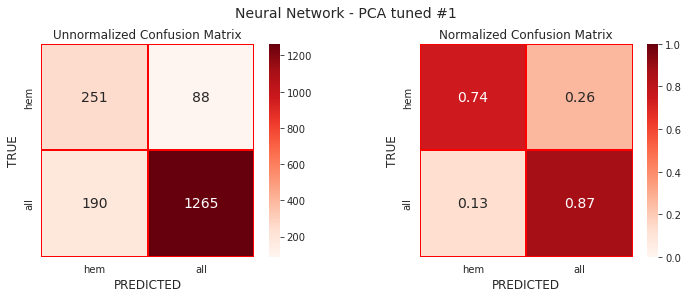

In [38]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network - PCA tuned #1', y_test, y_pred, target_names, 'Reds')

In [39]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.57      0.74      0.64       339
         all       0.93      0.87      0.90      1455

    accuracy                           0.85      1794
   macro avg       0.75      0.80      0.77      1794
weighted avg       0.87      0.85      0.85      1794



## PCA - Tuned - short window

In [100]:
# Define model with pipeline
num_pca_components = 1000
pipe = Pipeline(
    steps = (
        ('scaler', MinMaxScaler()),
        ('pca', PCA(num_pca_components)),
        ('clf', clf)
    )
)

## Optuna Objective Function

In [101]:
def objective(trial):
    """Define the objective function"""

    n_layers = trial.suggest_int('n_layers', 1, 2) # no. of hidden layers 
 
    layers = [300]  # max nodes in layers
    for i in range(n_layers):
        layers.append(trial.suggest_int(f"n_units_{i+1}", 20, layers[i], 20)) # no. of hidden unit
    
    
    params = {
        'pca__n_components' : trial.suggest_int('pca__n_components', 900, 1200),
        'clf__epochs' : trial.suggest_int('clf__epochs', 10, 150, 10),
        'clf__batch_size' : trial.suggest_categorical('clf__batch_size', [32, 64, 128]),
        ### 'clf__model__dropout' : trial.suggest_float('clf__model__dropout', 0.2, 0.6, step=0.1),
        'clf__model__dropout' : trial.suggest_float('clf__model__dropout', 0.2, 0.6),
         ###'clf__model__hidden_layer_sizes' : [(100, ), (50, 50, )],
        'clf__optimizer__learning_rate' : trial.suggest_float('clf__optimizer__learning_rate', 1e-5, 1e-1, log=True),
    }
    
    params['clf__model__hidden_layer_sizes'] = tuple(layers[1:])

    pipe.set_params(**params)
   
    # Fit the model
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [102]:
study = optuna.create_study(direction='maximize')

[I 2023-05-03 06:39:41,454] A new study created in memory with name: no-name-751867b0-d455-4a59-95c1-49a9bb08bf02


## Optimize the Objective Function

In [103]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 06:41:38,942] Trial 0 finished with value: 0.7764261001283383 and parameters: {'n_layers': 2, 'n_units_1': 220, 'n_units_2': 40, 'pca__n_components': 1108, 'clf__epochs': 60, 'clf__batch_size': 32, 'clf__model__dropout': 0.4691816022944599, 'clf__optimizer__learning_rate': 0.0014792768021524242}. Best is trial 0 with value: 0.7764261001283383.
[I 2023-05-03 06:44:03,194] Trial 1 finished with value: 0.7713502084051098 and parameters: {'n_layers': 2, 'n_units_1': 280, 'n_units_2': 160, 'pca__n_components': 1005, 'clf__epochs': 150, 'clf__batch_size': 64, 'clf__model__dropout': 0.3413028276667405, 'clf__optimizer__learning_rate': 1.1813574371110236e-05}. Best is trial 0 with value: 0.7764261001283383.
[I 2023-05-03 06:44:25,531] Trial 2 finished with value: 0.7843901771011943 and parameters: {'n_layers': 2, 'n_units_1': 140, 'n_units_2': 100, 'pca__n_components': 902, 'clf__epochs': 10, 'clf__batch_size': 64, 'clf__model__dropout': 0.4153111464013849, 'clf__optimizer__learn

In [104]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 07:32:07,445] Trial 20 finished with value: 0.7780489157561976 and parameters: {'n_layers': 1, 'n_units_1': 60, 'pca__n_components': 1084, 'clf__epochs': 100, 'clf__batch_size': 32, 'clf__model__dropout': 0.24269815065790834, 'clf__optimizer__learning_rate': 0.0037835179241283517}. Best is trial 14 with value: 0.7856612038595616.
[I 2023-05-03 07:35:38,205] Trial 21 finished with value: 0.7717011971133034 and parameters: {'n_layers': 1, 'n_units_1': 20, 'pca__n_components': 987, 'clf__epochs': 130, 'clf__batch_size': 32, 'clf__model__dropout': 0.20177690640712534, 'clf__optimizer__learning_rate': 0.0006485618078787064}. Best is trial 14 with value: 0.7856612038595616.
[I 2023-05-03 07:38:34,196] Trial 22 finished with value: 0.7821383732400682 and parameters: {'n_layers': 1, 'n_units_1': 40, 'pca__n_components': 903, 'clf__epochs': 110, 'clf__batch_size': 32, 'clf__model__dropout': 0.24700070166215357, 'clf__optimizer__learning_rate': 0.0007974316123372202}. Best is trial

In [118]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 08:21:44,150] Trial 40 finished with value: 0.7802746873740789 and parameters: {'n_layers': 1, 'n_units_1': 80, 'pca__n_components': 1047, 'clf__epochs': 60, 'clf__batch_size': 128, 'clf__model__dropout': 0.32304548329059257, 'clf__optimizer__learning_rate': 0.00035253154846520625}. Best is trial 30 with value: 0.8000568400287543.
[I 2023-05-03 08:23:24,427] Trial 41 finished with value: 0.7861205330740119 and parameters: {'n_layers': 1, 'n_units_1': 60, 'pca__n_components': 903, 'clf__epochs': 100, 'clf__batch_size': 64, 'clf__model__dropout': 0.29156903925899247, 'clf__optimizer__learning_rate': 0.00046051489370908837}. Best is trial 30 with value: 0.8000568400287543.
[I 2023-05-03 08:25:02,636] Trial 42 finished with value: 0.7892001117663713 and parameters: {'n_layers': 1, 'n_units_1': 40, 'pca__n_components': 943, 'clf__epochs': 100, 'clf__batch_size': 64, 'clf__model__dropout': 0.2877116586496932, 'clf__optimizer__learning_rate': 0.0011131979214443347}. Best is tria

In [119]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 08:53:09,762] Trial 60 finished with value: 0.7784225710414497 and parameters: {'n_layers': 1, 'n_units_1': 200, 'pca__n_components': 1026, 'clf__epochs': 130, 'clf__batch_size': 128, 'clf__model__dropout': 0.4130072834962804, 'clf__optimizer__learning_rate': 0.00018743926280413505}. Best is trial 30 with value: 0.8000568400287543.
[I 2023-05-03 08:55:23,510] Trial 61 finished with value: 0.7809016930849628 and parameters: {'n_layers': 1, 'n_units_1': 120, 'pca__n_components': 943, 'clf__epochs': 150, 'clf__batch_size': 64, 'clf__model__dropout': 0.2939618820269957, 'clf__optimizer__learning_rate': 0.00046011630234180014}. Best is trial 30 with value: 0.8000568400287543.
[I 2023-05-03 08:57:19,130] Trial 62 finished with value: 0.7670311827429699 and parameters: {'n_layers': 1, 'n_units_1': 140, 'pca__n_components': 956, 'clf__epochs': 140, 'clf__batch_size': 64, 'clf__model__dropout': 0.31458864405853915, 'clf__optimizer__learning_rate': 0.000550318181984559}. Best is tr

In [133]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 09:29:04,914] Trial 80 finished with value: 0.7929133421985815 and parameters: {'n_layers': 1, 'n_units_1': 300, 'pca__n_components': 1146, 'clf__epochs': 140, 'clf__batch_size': 128, 'clf__model__dropout': 0.33679615164471133, 'clf__optimizer__learning_rate': 0.0008737976712892082}. Best is trial 76 with value: 0.8016026949775419.
[I 2023-05-03 09:30:19,281] Trial 81 finished with value: 0.7817296968468012 and parameters: {'n_layers': 1, 'n_units_1': 300, 'pca__n_components': 1143, 'clf__epochs': 140, 'clf__batch_size': 128, 'clf__model__dropout': 0.33248306281092926, 'clf__optimizer__learning_rate': 0.000855951423816862}. Best is trial 76 with value: 0.8016026949775419.
[I 2023-05-03 09:31:29,186] Trial 82 finished with value: 0.7887979621197514 and parameters: {'n_layers': 1, 'n_units_1': 280, 'pca__n_components': 1178, 'clf__epochs': 140, 'clf__batch_size': 128, 'clf__model__dropout': 0.342975370899129, 'clf__optimizer__learning_rate': 0.0015303536669800282}. Best is 

## Best Parameters

In [134]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.8016026949775419
  Params: 
    n_layers: 1
    n_units_1: 260
    pca__n_components: 1056
    clf__epochs: 120
    clf__batch_size: 128
    clf__model__dropout: 0.3068920343908312
    clf__optimizer__learning_rate: 0.0021838722078525593


## Re-fit the model

In [121]:
params_t = trial.params
params_t

{'n_layers': 1,
 'n_units_1': 260,
 'pca__n_components': 1056,
 'clf__epochs': 120,
 'clf__batch_size': 128,
 'clf__model__dropout': 0.3068920343908312,
 'clf__optimizer__learning_rate': 0.0021838722078525593}

In [122]:
### params = {k:v for k,v in params_t.items() if k.startswith('clf')}
params = {k:v for k,v in params_t.items() if '__' in k}
params

{'pca__n_components': 1056,
 'clf__epochs': 120,
 'clf__batch_size': 128,
 'clf__model__dropout': 0.3068920343908312,
 'clf__optimizer__learning_rate': 0.0021838722078525593}

In [123]:
# if 'n_units_2' in params_t:
#     params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'], params_t['n_units_2'])
# else:
#     params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'],)
    

params['clf__model__hidden_layer_sizes'] = tuple([v for k,v in params_t.items() if 'n_units' in k])
params

{'pca__n_components': 1056,
 'clf__epochs': 120,
 'clf__batch_size': 128,
 'clf__model__dropout': 0.3068920343908312,
 'clf__optimizer__learning_rate': 0.0021838722078525593,
 'clf__model__hidden_layer_sizes': (260,)}

In [124]:
pipe.set_params(**params)
    ## model = SVC(**params, kernel='linear', random_state=random_state)
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=1056)),
                ('clf',
                 KerasClassifier(batch_size=128, epochs=120, loss='binary_crossentropy', model=<function get_clf at 0x7f39054775b0>, model__dropout=0.3068920343908312, model__hidden_layer_sizes=(260,), optimizer='adam', optimizer__learning_rate=0.0021838722078525593, random_state=10, verbose=0))])

In [125]:
# Save the model
# joblib.dump(mlp, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/nn_pca_1.pkl')
joblib.dump(pipe, './saved_models/batch_4_stack/nn_pca_t_2a.pkl')

INFO:tensorflow:Assets written to: ram://106dc578152b40dfaa11d3c121cb2030/assets


['./saved_models/batch_4_stack/nn_pca_t_2a.pkl']

In [126]:
pipe['clf'].model_.summary()

Model: "sequential_286"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_943 (Dense)           (None, 1056)              1116192   
                                                                 
 dense_944 (Dense)           (None, 260)               274820    
                                                                 
 dropout_371 (Dropout)       (None, 260)               0         
                                                                 
 dense_945 (Dense)           (None, 1)                 261       
                                                                 
Total params: 1,391,273
Trainable params: 1,391,273
Non-trainable params: 0
_________________________________________________________________


In [127]:
y_pred = pipe.predict(X_test)

In [128]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 85.73


In [129]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8573021181716833


In [130]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 255   84]
 [ 172 1283]]


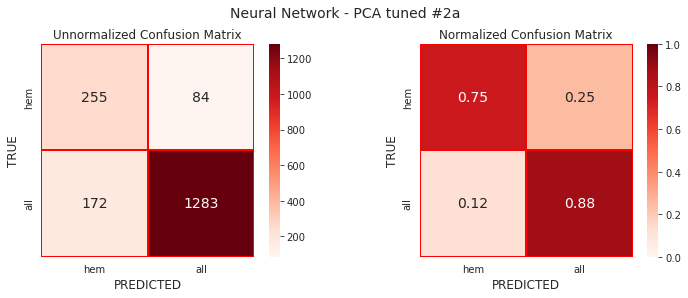

In [131]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network - PCA tuned #2a', y_test, y_pred, target_names, 'Reds')

In [132]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.60      0.75      0.67       339
         all       0.94      0.88      0.91      1455

    accuracy                           0.86      1794
   macro avg       0.77      0.82      0.79      1794
weighted avg       0.87      0.86      0.86      1794



### PCA - Tuned   

- PCA 900 - 1200
- num of layers 1 - 3
- max nodes in layers 500
- added 256 batch size - 32, 64, 128, 256
- dropout step changed to 0.0001
- increased max # epochs to 300


- added early stopping

In [140]:
clf = KerasClassifier(
    model=km.get_clf,
    loss="binary_crossentropy",
    model__hidden_layer_sizes=(10, 10),
    model__dropout=0.5,
    batch_size=64,
    optimizer='adam',
    optimizer__learning_rate=0.0001,
    epochs=100,
    verbose=0,
    callbacks=EarlyStopping,
    callbacks__monitor="loss",
    callbacks__patience=5,
    random_state=random_state,  
)

In [141]:
# Define model with pipeline
num_pca_components = 1000
pipe = Pipeline(
    steps = (
        ('scaler', MinMaxScaler()),
        ('pca', PCA(num_pca_components)),
        ('clf', clf)
    )
)

## Optuna Objective Function

In [145]:
def objective(trial):
    """Define the objective function"""

    n_layers = trial.suggest_int('n_layers', 1, 3) # no. of hidden layers 
 
    layers = [500]  # max nodes in layers
    for i in range(n_layers):
        layers.append(trial.suggest_int(f"n_units_{i+1}", 20, layers[i], 20)) # no. of hidden unit
    
    
    params = {
        'pca__n_components' : trial.suggest_int('pca__n_components', 900, 1200),
        'clf__epochs' : trial.suggest_int('clf__epochs', 10, 300, 10),
        'clf__batch_size' : trial.suggest_categorical('clf__batch_size', [32, 64, 128, 256]),
        ### 'clf__model__dropout' : trial.suggest_float('clf__model__dropout', 0.2, 0.6, step=0.1),
        'clf__model__dropout' : trial.suggest_float('clf__model__dropout', 0.2, 0.6, step=0.0001),
         ###'clf__model__hidden_layer_sizes' : [(100, ), (50, 50, )],
        'clf__optimizer__learning_rate' : trial.suggest_float('clf__optimizer__learning_rate', 1e-5, 1e-1, log=True),
    }
    
    params['clf__model__hidden_layer_sizes'] = tuple(layers[1:])

    pipe.set_params(**params)
   
    # Fit the model
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [146]:
study = optuna.create_study(direction='maximize')

[I 2023-05-03 11:15:15,251] A new study created in memory with name: no-name-7ee4203c-8d68-4766-add0-4db6d34eeb90


## Optimize the Objective Function

In [147]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 11:15:46,879] Trial 0 finished with value: 0.46241909539785186 and parameters: {'n_layers': 3, 'n_units_1': 100, 'n_units_2': 80, 'n_units_3': 20, 'pca__n_components': 976, 'clf__epochs': 210, 'clf__batch_size': 128, 'clf__model__dropout': 0.5075000000000001, 'clf__optimizer__learning_rate': 0.02655358323767822}. Best is trial 0 with value: 0.46241909539785186.
[I 2023-05-03 11:16:09,772] Trial 1 finished with value: 0.48261197248445825 and parameters: {'n_layers': 1, 'n_units_1': 200, 'pca__n_components': 1137, 'clf__epochs': 180, 'clf__batch_size': 128, 'clf__model__dropout': 0.5281, 'clf__optimizer__learning_rate': 0.06192387907758219}. Best is trial 1 with value: 0.48261197248445825.
[I 2023-05-03 11:16:32,950] Trial 2 finished with value: 0.7686193565827315 and parameters: {'n_layers': 3, 'n_units_1': 340, 'n_units_2': 140, 'n_units_3': 120, 'pca__n_components': 1187, 'clf__epochs': 300, 'clf__batch_size': 256, 'clf__model__dropout': 0.32080000000000003, 'clf__optimi

In [149]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 11:34:30,549] Trial 20 finished with value: 0.7825607452078318 and parameters: {'n_layers': 2, 'n_units_1': 140, 'n_units_2': 100, 'pca__n_components': 1163, 'clf__epochs': 120, 'clf__batch_size': 32, 'clf__model__dropout': 0.4487, 'clf__optimizer__learning_rate': 0.002285874045348591}. Best is trial 10 with value: 0.7879866746073103.
[I 2023-05-03 11:35:57,587] Trial 21 finished with value: 0.7678933766501052 and parameters: {'n_layers': 1, 'n_units_1': 320, 'pca__n_components': 931, 'clf__epochs': 50, 'clf__batch_size': 32, 'clf__model__dropout': 0.2119, 'clf__optimizer__learning_rate': 5.5680381911288065e-05}. Best is trial 10 with value: 0.7879866746073103.
[I 2023-05-03 11:37:12,186] Trial 22 finished with value: 0.7927575128451965 and parameters: {'n_layers': 1, 'n_units_1': 360, 'pca__n_components': 998, 'clf__epochs': 40, 'clf__batch_size': 32, 'clf__model__dropout': 0.20340000000000003, 'clf__optimizer__learning_rate': 0.00022766424055840415}. Best is trial 22 wi

In [150]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 11:59:02,979] Trial 40 finished with value: 0.7863413638219681 and parameters: {'n_layers': 2, 'n_units_1': 300, 'n_units_2': 220, 'pca__n_components': 1185, 'clf__epochs': 50, 'clf__batch_size': 32, 'clf__model__dropout': 0.37220000000000003, 'clf__optimizer__learning_rate': 0.0015574230411887196}. Best is trial 22 with value: 0.7927575128451965.
[I 2023-05-03 12:00:06,057] Trial 41 finished with value: 0.7647781823241575 and parameters: {'n_layers': 2, 'n_units_1': 300, 'n_units_2': 200, 'pca__n_components': 1176, 'clf__epochs': 50, 'clf__batch_size': 32, 'clf__model__dropout': 0.3768, 'clf__optimizer__learning_rate': 0.0003128034937699668}. Best is trial 22 with value: 0.7927575128451965.
[I 2023-05-03 12:01:03,477] Trial 42 finished with value: 0.7860760412168584 and parameters: {'n_layers': 2, 'n_units_1': 340, 'n_units_2': 240, 'pca__n_components': 1195, 'clf__epochs': 90, 'clf__batch_size': 32, 'clf__model__dropout': 0.338, 'clf__optimizer__learning_rate': 0.003855

In [161]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 13:44:24,468] Trial 60 finished with value: 0.7774078393075192 and parameters: {'n_layers': 3, 'n_units_1': 360, 'n_units_2': 140, 'n_units_3': 60, 'pca__n_components': 1076, 'clf__epochs': 30, 'clf__batch_size': 256, 'clf__model__dropout': 0.26170000000000004, 'clf__optimizer__learning_rate': 0.005651042908123288}. Best is trial 58 with value: 0.7971266911908264.
[I 2023-05-03 13:45:21,401] Trial 61 finished with value: 0.791893794429958 and parameters: {'n_layers': 2, 'n_units_1': 320, 'n_units_2': 260, 'pca__n_components': 1035, 'clf__epochs': 70, 'clf__batch_size': 32, 'clf__model__dropout': 0.3427, 'clf__optimizer__learning_rate': 0.0029530079128290807}. Best is trial 58 with value: 0.7971266911908264.
[I 2023-05-03 13:47:02,840] Trial 62 finished with value: 0.7798689666906449 and parameters: {'n_layers': 2, 'n_units_1': 280, 'n_units_2': 260, 'pca__n_components': 1036, 'clf__epochs': 70, 'clf__batch_size': 32, 'clf__model__dropout': 0.39170000000000005, 'clf__optim

## Best Parameters

In [151]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 60
Best trial:
  Value: 0.7971266911908264
  Params: 
    n_layers: 3
    n_units_1: 360
    n_units_2: 140
    n_units_3: 60
    pca__n_components: 1064
    clf__epochs: 50
    clf__batch_size: 32
    clf__model__dropout: 0.29500000000000004
    clf__optimizer__learning_rate: 0.005271732594888075


## Re-fit the model

In [152]:
params_t = trial.params
params_t

{'n_layers': 3,
 'n_units_1': 360,
 'n_units_2': 140,
 'n_units_3': 60,
 'pca__n_components': 1064,
 'clf__epochs': 50,
 'clf__batch_size': 32,
 'clf__model__dropout': 0.29500000000000004,
 'clf__optimizer__learning_rate': 0.005271732594888075}

In [153]:
### params = {k:v for k,v in params_t.items() if k.startswith('clf')}
params = {k:v for k,v in params_t.items() if '__' in k}
params

{'pca__n_components': 1064,
 'clf__epochs': 50,
 'clf__batch_size': 32,
 'clf__model__dropout': 0.29500000000000004,
 'clf__optimizer__learning_rate': 0.005271732594888075}

In [154]:
# if 'n_units_2' in params_t:
#     params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'], params_t['n_units_2'])
# else:
#     params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'],)
    

params['clf__model__hidden_layer_sizes'] = tuple([v for k,v in params_t.items() if 'n_units' in k])
params

{'pca__n_components': 1064,
 'clf__epochs': 50,
 'clf__batch_size': 32,
 'clf__model__dropout': 0.29500000000000004,
 'clf__optimizer__learning_rate': 0.005271732594888075,
 'clf__model__hidden_layer_sizes': (360, 140, 60)}

In [155]:
pipe.set_params(**params)
    ## model = SVC(**params, kernel='linear', random_state=random_state)
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=1064)),
                ('clf',
                 KerasClassifier(batch_size=32, callbacks=<class 'keras.callbacks.EarlyStopping'>, callbacks__monitor='loss', callbacks__patience=5, epochs=50, loss='binary_crossentropy', model=<function get_clf at 0x7f39054775b0>, model__dropout=0.29500000000000004, model__hidden_layer_sizes=(360, 140, 60), optimizer='adam', optimizer__learning_rate=0.005271732594888075, random_state=10, verbose=0))])

In [125]:
# Save the model
# joblib.dump(mlp, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/nn_pca_1.pkl')
joblib.dump(pipe, './saved_models/batch_4_stack/nn_pca_t_2a.pkl')

INFO:tensorflow:Assets written to: ram://106dc578152b40dfaa11d3c121cb2030/assets


['./saved_models/batch_4_stack/nn_pca_t_2a.pkl']

In [156]:
pipe['clf'].model_.summary()

Model: "sequential_367"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1239 (Dense)          (None, 1064)              1133160   
                                                                 
 dense_1240 (Dense)          (None, 360)               383400    
                                                                 
 dropout_505 (Dropout)       (None, 360)               0         
                                                                 
 dense_1241 (Dense)          (None, 140)               50540     
                                                                 
 dropout_506 (Dropout)       (None, 140)               0         
                                                                 
 dense_1242 (Dense)          (None, 60)                8460      
                                                                 
 dropout_507 (Dropout)       (None, 60)             

In [157]:
y_pred = pipe.predict(X_test)

In [158]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 83.89


In [159]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

Training Data Score: 0.9941260384324914
Testing Data Score: 0.8389074693422519


In [160]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 254   85]
 [ 204 1251]]


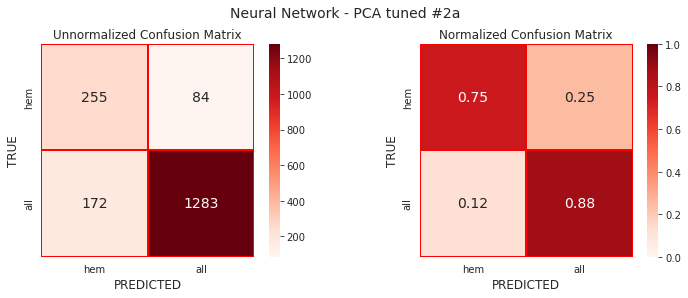

In [131]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network - PCA tuned #2a', y_test, y_pred, target_names, 'Reds')

In [132]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.60      0.75      0.67       339
         all       0.94      0.88      0.91      1455

    accuracy                           0.86      1794
   macro avg       0.77      0.82      0.79      1794
weighted avg       0.87      0.86      0.86      1794



### PCA - 1000  

- num of layers 1 - 3
- max nodes in layers 500
- added 256 batch size - 32, 64, 128, 256
- dropout step changed to 0.0001
- increased max # epochs to 300


- added early stopping

In [169]:
clf = KerasClassifier(
    model=km.get_clf,
    loss="binary_crossentropy",
    model__hidden_layer_sizes=(10, 10),
    model__dropout=0.5,
    batch_size=64,
    optimizer='adam',
    optimizer__learning_rate=0.0001,
    epochs=100,
    verbose=0,
    callbacks=EarlyStopping,
    callbacks__monitor="loss",
    callbacks__patience=5,
    random_state=random_state,  
)

In [170]:
# Define model with pipeline
num_pca_components = 1000
pipe = Pipeline(
    steps = (
        ('scaler', MinMaxScaler()),
        ('pca', PCA(num_pca_components)),
        ('clf', clf)
    )
)

## Optuna Objective Function

In [171]:
def objective(trial):
    """Define the objective function"""

    n_layers = trial.suggest_int('n_layers', 1, 3) # no. of hidden layers 
 
    layers = [500]  # max nodes in layers
    for i in range(n_layers):
        layers.append(trial.suggest_int(f"n_units_{i+1}", 20, 500, 10)) # no. of hidden unit
    
    
    params = {
        #'pca__n_components' : trial.suggest_int('pca__n_components', 900, 1200),
        'clf__epochs' : trial.suggest_int('clf__epochs', 10, 300, 10),
        'clf__batch_size' : trial.suggest_categorical('clf__batch_size', [32, 64, 128, 256]),
        ### 'clf__model__dropout' : trial.suggest_float('clf__model__dropout', 0.2, 0.6, step=0.1),
        'clf__model__dropout' : trial.suggest_float('clf__model__dropout', 0.2, 0.6, step=0.0001),
         ###'clf__model__hidden_layer_sizes' : [(100, ), (50, 50, )],
        'clf__optimizer__learning_rate' : trial.suggest_float('clf__optimizer__learning_rate', 1e-5, 1e-1, log=True),
    }
    
    params['clf__model__hidden_layer_sizes'] = tuple(layers[1:])

    pipe.set_params(**params)
   
    # Fit the model
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [172]:
study = optuna.create_study(direction='maximize')

[I 2023-05-03 18:05:16,921] A new study created in memory with name: no-name-af47ea3b-5e36-42f0-a921-8c4ad356adf3


## Optimize the Objective Function

In [173]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 18:06:14,989] Trial 0 finished with value: 0.7772079772079772 and parameters: {'n_layers': 2, 'n_units_1': 110, 'n_units_2': 390, 'clf__epochs': 20, 'clf__batch_size': 64, 'clf__model__dropout': 0.5639000000000001, 'clf__optimizer__learning_rate': 7.89425184079927e-05}. Best is trial 0 with value: 0.7772079772079772.
[I 2023-05-03 18:07:21,376] Trial 1 finished with value: 0.7765956427752642 and parameters: {'n_layers': 2, 'n_units_1': 350, 'n_units_2': 80, 'clf__epochs': 80, 'clf__batch_size': 32, 'clf__model__dropout': 0.20650000000000002, 'clf__optimizer__learning_rate': 0.00022021727829382557}. Best is trial 0 with value: 0.7772079772079772.
[I 2023-05-03 18:08:16,207] Trial 2 finished with value: 0.7852758764741798 and parameters: {'n_layers': 2, 'n_units_1': 160, 'n_units_2': 340, 'clf__epochs': 40, 'clf__batch_size': 128, 'clf__model__dropout': 0.24980000000000002, 'clf__optimizer__learning_rate': 0.003630971677402474}. Best is trial 2 with value: 0.785275876474179

In [187]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 18:38:25,673] Trial 20 finished with value: 0.780056895680515 and parameters: {'n_layers': 2, 'n_units_1': 300, 'n_units_2': 180, 'clf__epochs': 10, 'clf__batch_size': 128, 'clf__model__dropout': 0.4307, 'clf__optimizer__learning_rate': 0.00687817334571339}. Best is trial 13 with value: 0.8040344026323973.
[I 2023-05-03 18:39:07,687] Trial 21 finished with value: 0.7782323047329545 and parameters: {'n_layers': 2, 'n_units_1': 170, 'n_units_2': 240, 'clf__epochs': 40, 'clf__batch_size': 128, 'clf__model__dropout': 0.4425, 'clf__optimizer__learning_rate': 0.0027447245325567656}. Best is trial 13 with value: 0.8040344026323973.
[I 2023-05-03 18:39:41,572] Trial 22 finished with value: 0.7816935558570487 and parameters: {'n_layers': 1, 'n_units_1': 150, 'clf__epochs': 60, 'clf__batch_size': 128, 'clf__model__dropout': 0.5084, 'clf__optimizer__learning_rate': 0.0016319727993535662}. Best is trial 13 with value: 0.8040344026323973.
[I 2023-05-03 18:40:16,941] Trial 23 finished 

In [188]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 18:56:32,172] Trial 40 finished with value: 0.7768060981523558 and parameters: {'n_layers': 1, 'n_units_1': 500, 'clf__epochs': 170, 'clf__batch_size': 128, 'clf__model__dropout': 0.3175, 'clf__optimizer__learning_rate': 0.00012360795059076233}. Best is trial 13 with value: 0.8040344026323973.
[I 2023-05-03 18:57:03,007] Trial 41 finished with value: 0.7821405440414507 and parameters: {'n_layers': 2, 'n_units_1': 140, 'n_units_2': 310, 'clf__epochs': 40, 'clf__batch_size': 128, 'clf__model__dropout': 0.2334, 'clf__optimizer__learning_rate': 0.002710556921658981}. Best is trial 13 with value: 0.8040344026323973.
[I 2023-05-03 18:57:25,786] Trial 42 finished with value: 0.7520876517619188 and parameters: {'n_layers': 2, 'n_units_1': 340, 'n_units_2': 390, 'clf__epochs': 70, 'clf__batch_size': 128, 'clf__model__dropout': 0.2177, 'clf__optimizer__learning_rate': 0.002327675249614057}. Best is trial 13 with value: 0.8040344026323973.
[I 2023-05-03 18:58:20,455] Trial 43 finish

In [189]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 19:11:20,784] Trial 60 finished with value: 0.7892991123799304 and parameters: {'n_layers': 2, 'n_units_1': 240, 'n_units_2': 500, 'clf__epochs': 100, 'clf__batch_size': 128, 'clf__model__dropout': 0.38380000000000003, 'clf__optimizer__learning_rate': 0.0010642281587648563}. Best is trial 13 with value: 0.8040344026323973.
[I 2023-05-03 19:11:53,750] Trial 61 finished with value: 0.7937047395858513 and parameters: {'n_layers': 2, 'n_units_1': 180, 'n_units_2': 410, 'clf__epochs': 80, 'clf__batch_size': 128, 'clf__model__dropout': 0.24630000000000002, 'clf__optimizer__learning_rate': 0.001240759534697943}. Best is trial 13 with value: 0.8040344026323973.
[I 2023-05-03 19:12:32,870] Trial 62 finished with value: 0.7968294774969358 and parameters: {'n_layers': 2, 'n_units_1': 190, 'n_units_2': 380, 'clf__epochs': 50, 'clf__batch_size': 128, 'clf__model__dropout': 0.22910000000000003, 'clf__optimizer__learning_rate': 0.00226409315196577}. Best is trial 13 with value: 0.804034

In [ ]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 19:33:30,288] Trial 80 finished with value: 0.7745407281928023 and parameters: {'n_layers': 2, 'n_units_1': 230, 'n_units_2': 470, 'clf__epochs': 100, 'clf__batch_size': 64, 'clf__model__dropout': 0.3799, 'clf__optimizer__learning_rate': 0.0007722390966952948}. Best is trial 78 with value: 0.810086956521739.
[I 2023-05-03 19:34:38,959] Trial 81 finished with value: 0.7846298758865249 and parameters: {'n_layers': 2, 'n_units_1': 170, 'n_units_2': 390, 'clf__epochs': 90, 'clf__batch_size': 64, 'clf__model__dropout': 0.33720000000000006, 'clf__optimizer__learning_rate': 0.0013170900523359792}. Best is trial 78 with value: 0.810086956521739.
[I 2023-05-03 19:37:05,688] Trial 82 finished with value: 0.775765092734143 and parameters: {'n_layers': 2, 'n_units_1': 140, 'n_units_2': 220, 'clf__epochs': 70, 'clf__batch_size': 64, 'clf__model__dropout': 0.4165, 'clf__optimizer__learning_rate': 0.0008755569276845393}. Best is trial 78 with value: 0.810086956521739.
[I 2023-05-03 19:3

## Best Parameters

In [190]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 80
Best trial:
  Value: 0.810086956521739
  Params: 
    n_layers: 2
    n_units_1: 190
    n_units_2: 410
    clf__epochs: 100
    clf__batch_size: 64
    clf__model__dropout: 0.3266
    clf__optimizer__learning_rate: 0.0008617019774853403


## Re-fit the model

In [191]:
params_t = trial.params
params_t

{'n_layers': 2,
 'n_units_1': 190,
 'n_units_2': 410,
 'clf__epochs': 100,
 'clf__batch_size': 64,
 'clf__model__dropout': 0.3266,
 'clf__optimizer__learning_rate': 0.0008617019774853403}

In [192]:
### params = {k:v for k,v in params_t.items() if k.startswith('clf')}
params = {k:v for k,v in params_t.items() if '__' in k}
params

{'clf__epochs': 100,
 'clf__batch_size': 64,
 'clf__model__dropout': 0.3266,
 'clf__optimizer__learning_rate': 0.0008617019774853403}

In [193]:
# if 'n_units_2' in params_t:
#     params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'], params_t['n_units_2'])
# else:
#     params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'],)
    

params['clf__model__hidden_layer_sizes'] = tuple([v for k,v in params_t.items() if 'n_units' in k])
params

{'clf__epochs': 100,
 'clf__batch_size': 64,
 'clf__model__dropout': 0.3266,
 'clf__optimizer__learning_rate': 0.0008617019774853403,
 'clf__model__hidden_layer_sizes': (190, 410)}

In [194]:
pipe.set_params(**params)
    ## model = SVC(**params, kernel='linear', random_state=random_state)
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=1000)),
                ('clf',
                 KerasClassifier(batch_size=64, callbacks=<class 'keras.callbacks.EarlyStopping'>, callbacks__monitor='loss', callbacks__patience=5, epochs=100, loss='binary_crossentropy', model=<function get_clf at 0x7f39054775b0>, model__dropout=0.3266, model__hidden_layer_sizes=(190, 410), optimizer='adam', optimizer__learning_rate=0.0008617019774853403, random_state=10, verbose=0))])

In [186]:
# Save the model
# joblib.dump(mlp, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/nn_pca_1.pkl')
joblib.dump(pipe, './saved_models/batch_4_stack/nn_pca_3a.pkl')

INFO:tensorflow:Assets written to: ram://3b1931015e8e4161af12e60aa1778e7f/assets


['./saved_models/batch_4_stack/nn_pca_3.pkl']

In [195]:
pipe['clf'].model_.summary()

Model: "sequential_549"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1921 (Dense)          (None, 1000)              1001000   
                                                                 
 dense_1922 (Dense)          (None, 190)               190190    
                                                                 
 dropout_823 (Dropout)       (None, 190)               0         
                                                                 
 dense_1923 (Dense)          (None, 410)               78310     
                                                                 
 dropout_824 (Dropout)       (None, 410)               0         
                                                                 
 dense_1924 (Dense)          (None, 1)                 411       
                                                                 
Total params: 1,269,911
Trainable params: 1,269,911


In [196]:
y_pred = pipe.predict(X_test)

In [197]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 85.73


In [198]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

Training Data Score: 0.9988252076864983
Testing Data Score: 0.8573021181716833


In [199]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 237  102]
 [ 154 1301]]


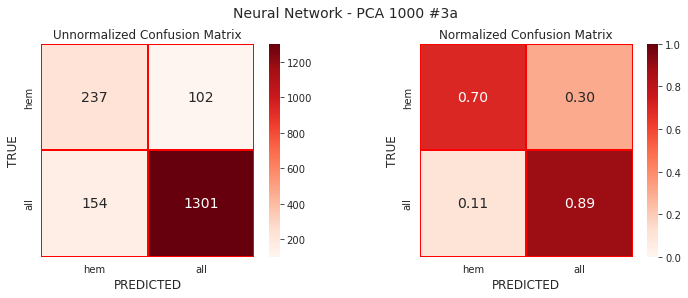

In [200]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network - PCA 1000 #3a', y_test, y_pred, target_names, 'Reds')

In [201]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.61      0.70      0.65       339
         all       0.93      0.89      0.91      1455

    accuracy                           0.86      1794
   macro avg       0.77      0.80      0.78      1794
weighted avg       0.87      0.86      0.86      1794



# ANOVA - Tuned

In [42]:
# Define model with pipeline
fs = SelectKBest(score_func=f_classif) # ANOVA feature selection
pipe = Pipeline(
    steps = (
        ('scaler', MinMaxScaler()),
        ('anova', fs),
        ('clf', clf)
    )
)

## Optuna Objective Function

#### changed step for dropout and k range

In [67]:
def objective(trial):
    """Define the objective function"""

    n_layers = trial.suggest_int('n_layers', 1, 3) # no. of hidden layers 
    layers = [300]  # max nodes in layers
    for i in range(n_layers):
        layers.append(trial.suggest_int(f"n_units_{i+1}", 20, layers[i], 20)) # no. of hidden unit
    
    params = {
        'anova__k' : trial.suggest_int('anova__k', 800, 3000, 10),
        'clf__epochs' : trial.suggest_int('clf__epochs', 10, 150, 10),
        'clf__batch_size' : trial.suggest_categorical('clf__batch_size', [32, 64, 128]),
        'clf__model__dropout' : trial.suggest_float('clf__model__dropout', 0.2, 0.6, step=0.001),
        ### 'clf__model__dropout' : trial.suggest_float('clf__model__dropout', 0.2, 0.6),
         ###'clf__model__hidden_layer_sizes' : [(100, ), (50, 50, )],
        'clf__optimizer__learning_rate' : trial.suggest_float('clf__optimizer__learning_rate', 1e-5, 1e-1, log=True),
    }
    
    params['clf__model__hidden_layer_sizes'] = tuple(layers[1:])

    pipe.set_params(**params)
   
    # Fit the model
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [68]:
study = optuna.create_study(direction='maximize')

[I 2023-05-02 23:01:59,503] A new study created in memory with name: no-name-85c57cfd-511f-49b4-b638-2e6ddf58f69f


## Optimize the Objective Function

In [69]:
study.optimize(objective, n_trials=20)

[I 2023-05-02 23:04:37,559] Trial 0 finished with value: 0.7707088469905728 and parameters: {'n_layers': 2, 'n_units_1': 80, 'n_units_2': 20, 'anova__k': 2200, 'clf__epochs': 80, 'clf__batch_size': 32, 'clf__model__dropout': 0.222, 'clf__optimizer__learning_rate': 1.45250911305679e-05}. Best is trial 0 with value: 0.7707088469905728.
[I 2023-05-02 23:06:50,829] Trial 1 finished with value: 0.7488229405341865 and parameters: {'n_layers': 1, 'n_units_1': 180, 'anova__k': 2640, 'clf__epochs': 70, 'clf__batch_size': 32, 'clf__model__dropout': 0.227, 'clf__optimizer__learning_rate': 0.0031105402400949376}. Best is trial 0 with value: 0.7707088469905728.
[I 2023-05-02 23:07:07,228] Trial 2 finished with value: 0.7494763301214914 and parameters: {'n_layers': 2, 'n_units_1': 160, 'n_units_2': 80, 'anova__k': 840, 'clf__epochs': 30, 'clf__batch_size': 128, 'clf__model__dropout': 0.449, 'clf__optimizer__learning_rate': 0.006063601468151406}. Best is trial 0 with value: 0.7707088469905728.
[I 202

In [85]:
study.optimize(objective, n_trials=20)

[I 2023-05-02 23:39:50,085] Trial 20 finished with value: 0.7867642203409976 and parameters: {'n_layers': 1, 'n_units_1': 220, 'anova__k': 1080, 'clf__epochs': 120, 'clf__batch_size': 64, 'clf__model__dropout': 0.357, 'clf__optimizer__learning_rate': 5.975778454048737e-05}. Best is trial 20 with value: 0.7867642203409976.
[I 2023-05-02 23:41:30,518] Trial 21 finished with value: 0.7782228359899724 and parameters: {'n_layers': 1, 'n_units_1': 240, 'anova__k': 1050, 'clf__epochs': 120, 'clf__batch_size': 64, 'clf__model__dropout': 0.382, 'clf__optimizer__learning_rate': 6.449798069198383e-05}. Best is trial 20 with value: 0.7867642203409976.
[I 2023-05-02 23:43:10,825] Trial 22 finished with value: 0.7673789173789174 and parameters: {'n_layers': 1, 'n_units_1': 240, 'anova__k': 1000, 'clf__epochs': 110, 'clf__batch_size': 64, 'clf__model__dropout': 0.366, 'clf__optimizer__learning_rate': 6.423994369002325e-05}. Best is trial 20 with value: 0.7867642203409976.
[I 2023-05-02 23:45:47,659] 

In [86]:
study.optimize(objective, n_trials=20)

[I 2023-05-03 00:22:13,834] Trial 40 finished with value: 0.7540757363253856 and parameters: {'n_layers': 2, 'n_units_1': 160, 'n_units_2': 100, 'anova__k': 1140, 'clf__epochs': 60, 'clf__batch_size': 64, 'clf__model__dropout': 0.453, 'clf__optimizer__learning_rate': 1.7476483508361397e-05}. Best is trial 23 with value: 0.7903199735406974.
[I 2023-05-03 00:24:13,594] Trial 41 finished with value: 0.7715901725361893 and parameters: {'n_layers': 1, 'n_units_1': 300, 'anova__k': 1280, 'clf__epochs': 150, 'clf__batch_size': 64, 'clf__model__dropout': 0.48500000000000004, 'clf__optimizer__learning_rate': 1.0314592105149672e-05}. Best is trial 23 with value: 0.7903199735406974.
[I 2023-05-03 00:26:19,284] Trial 42 finished with value: 0.7829731826241135 and parameters: {'n_layers': 1, 'n_units_1': 300, 'anova__k': 1420, 'clf__epochs': 150, 'clf__batch_size': 64, 'clf__model__dropout': 0.537, 'clf__optimizer__learning_rate': 1.4525012702233273e-05}. Best is trial 23 with value: 0.790319973540

## Best Parameters

In [87]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 60
Best trial:
  Value: 0.7903199735406974
  Params: 
    n_layers: 1
    n_units_1: 220
    anova__k: 1060
    clf__epochs: 150
    clf__batch_size: 64
    clf__model__dropout: 0.404
    clf__optimizer__learning_rate: 1.7561118785998727e-05


## Re-fit the model

In [88]:
params_t = trial.params
params_t

{'n_layers': 1,
 'n_units_1': 220,
 'anova__k': 1060,
 'clf__epochs': 150,
 'clf__batch_size': 64,
 'clf__model__dropout': 0.404,
 'clf__optimizer__learning_rate': 1.7561118785998727e-05}

In [89]:
### params = {k:v for k,v in params_t.items() if k.startswith('clf')}
params = {k:v for k,v in params_t.items() if '__' in k}
params

{'anova__k': 1060,
 'clf__epochs': 150,
 'clf__batch_size': 64,
 'clf__model__dropout': 0.404,
 'clf__optimizer__learning_rate': 1.7561118785998727e-05}

In [90]:
# if 'n_units_2' in params_t:
#     params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'], params_t['n_units_2'])
# else:
#     params['clf__model__hidden_layer_sizes'] = (params_t['n_units_1'],)
    

params['clf__model__hidden_layer_sizes'] = tuple([v for k,v in params_t.items() if 'n_units' in k])
params

{'anova__k': 1060,
 'clf__epochs': 150,
 'clf__batch_size': 64,
 'clf__model__dropout': 0.404,
 'clf__optimizer__learning_rate': 1.7561118785998727e-05,
 'clf__model__hidden_layer_sizes': (220,)}

In [91]:
pipe.set_params(**params)
    ## model = SVC(**params, kernel='linear', random_state=random_state)
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('anova', SelectKBest(k=1060)),
                ('clf',
                 KerasClassifier(batch_size=64, epochs=150, loss='binary_crossentropy', model=<function get_clf at 0x7f39054775b0>, model__dropout=0.404, model__hidden_layer_sizes=(220,), optimizer='adam', optimizer__learning_rate=1.7561118785998727e-05, random_state=10, verbose=0))])

In [76]:
# Save the model
# joblib.dump(mlp, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/nn_pca_1.pkl')
joblib.dump(pipe, './saved_models/batch_4_stack/nn_anova_t_1.pkl')

INFO:tensorflow:Assets written to: ram://acb41987204b419db9836fdaeb5e4d75/assets


['./saved_models/batch_4_stack/nn_anova_t_1.pkl']

In [92]:
pipe['clf'].model_.summary()

Model: "sequential_204"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_686 (Dense)           (None, 1060)              1124660   
                                                                 
 dense_687 (Dense)           (None, 220)               233420    
                                                                 
 dropout_278 (Dropout)       (None, 220)               0         
                                                                 
 dense_688 (Dense)           (None, 1)                 221       
                                                                 
Total params: 1,358,301
Trainable params: 1,358,301
Non-trainable params: 0
_________________________________________________________________


In [93]:
y_pred = pipe.predict(X_test)

In [94]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 86.90


In [95]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

Training Data Score: 0.992867332382311
Testing Data Score: 0.8690078037904125


In [96]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 230  109]
 [ 126 1329]]


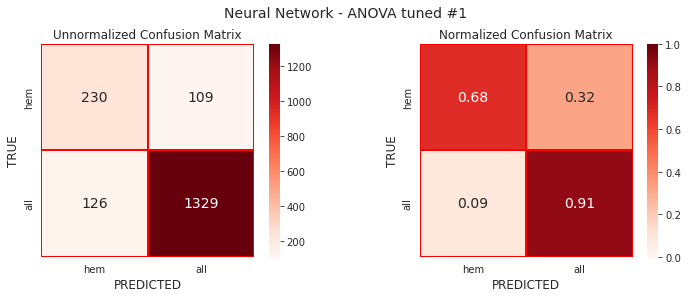

In [97]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network - ANOVA tuned #1', y_test, y_pred, target_names, 'Reds')

In [98]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.65      0.68      0.66       339
         all       0.92      0.91      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.79      0.80      0.79      1794
weighted avg       0.87      0.87      0.87      1794



# The Best Models

### Classifier

In [177]:
clf = KerasClassifier(
    model=km.get_clf,
    loss="binary_crossentropy",
    model__hidden_layer_sizes=(10, 10),
    model__dropout=0.5,
    batch_size=64,
    optimizer='adam',
    optimizer__learning_rate=0.0001,
    epochs=100,
    verbose=0,
    # callbacks=EarlyStopping,
    # callbacks__monitor="loss",
    # callbacks__patience=5,
    random_state=random_state,  
)

### Pipeline

In [178]:
# Define model with pipeline
num_pca_components = 1000
pipe = Pipeline(
    steps = (
        ('scaler', MinMaxScaler()),
        ('pca', PCA(num_pca_components, random_state=random_state)),
        ('clf', clf)
    )
)

 ## Model nn_pca_2

- Previously saved models can not be restored
- Piped models created with scikeras have to be stored differently, see below
- we will recreate the best performing models using their tuned hyperparameters (saved in the text doc)


### Function to save piped scikeras model

In [149]:
# Function to save piped scikeras model
def save_piped_model(model, model_name, step, folder):
    import os
    path_keras = os.path.join(folder, f"{model_name}_keras.h5")
    path_pipe = os.path.join(folder, f"{model_name}_pipeline.sav")
    
    # Save the Keras model first
    model.named_steps[step].model_.save(path_keras)
    # This hack allows us to save the pipeline
    model.named_steps[step].model_ = None
    # Save the pipeline
    joblib.dump(model, path_pipe)

### Function to load piped scikeras model

In [150]:
# Function to load piped scikeras model
def load_piped_model(model_name, step, folder):
    import os
    from tensorflow.keras.models import load_model
    path_keras = os.path.join(folder, f"{model_name}_keras.h5")
    path_pipe = os.path.join(folder, f"{model_name}_pipeline.sav")
    
    # Load the pipeline first
    loaded_model = joblib.load(path_pipe)
    # Then, load the Keras model
    loaded_model.named_steps[step].model_ = load_model(path_keras)
    return loaded_model

- This run was the best, but the repeated runs varied because I forgot to add random state in PCA step.
- All hyperparameter tuning in this notebook was done without random seed in the PCA step

In [158]:
params = {'clf__epochs': 100,
 'clf__batch_size': 128,
 'clf__model__dropout': 0.4,
 'clf__optimizer__learning_rate': 0.0005366554542437141,
 'clf__model__hidden_layer_sizes': (40, 240)}


In [146]:
pipe.set_params(**params)
    ## model = SVC(**params, kernel='linear', random_state=random_state)
nn_pca_2 = pipe.fit(X_train, y_train)

In [147]:
nn_pca_2

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=1000, random_state=10)),
                ('clf',
                 KerasClassifier(batch_size=128, epochs=100, loss='binary_crossentropy', model=<function get_clf at 0x7fec4a2bfbe0>, model__dropout=0.4, model__hidden_layer_sizes=(40, 240), optimizer='adam', optimizer__learning_rate=0.0005366554542437141, random_state=10, verbose=0))])

In [148]:
# Make predictions with the hypertuned model
y_pred = nn_pca_2.predict(X_test)

(1794,)

In [25]:
accuracy_score(y_test, y_pred)

0.8355629877369007

In [26]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 268   71]
 [ 224 1231]]


In [27]:
# Normalized confusion matrix
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.79 0.21]
 [0.15 0.85]]


### Using random seed in PCA

- This time we used random_seed in PCA step
- results are still pretty good

In [159]:
pipe.set_params(**params)
    ## model = SVC(**params, kernel='linear', random_state=random_state)
nn_pca_2 = pipe.fit(X_train, y_train)

In [160]:
nn_pca_2

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=1000, random_state=10)),
                ('clf',
                 KerasClassifier(batch_size=128, epochs=100, loss='binary_crossentropy', model=<function get_clf at 0x7fec4a2bfbe0>, model__dropout=0.4, model__hidden_layer_sizes=(40, 240), optimizer='adam', optimizer__learning_rate=0.0005366554542437141, random_state=10, verbose=0))])

In [161]:
# Make predictions with the hypertuned model
y_pred_pca2 = nn_pca_2.predict(X_test)

In [162]:
accuracy = accuracy_score(y_test, y_pred_pca2)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 85.62


In [163]:
# Compare training and testing scores
print(f"Training Data Score: {nn_pca_2.score(X_train, y_train)}")
print(f"Testing Data Score: {nn_pca_2.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8561872909698997


In [164]:
cm = confusion_matrix(y_test, y_pred_pca2)
print(cm)

[[ 263   76]
 [ 182 1273]]


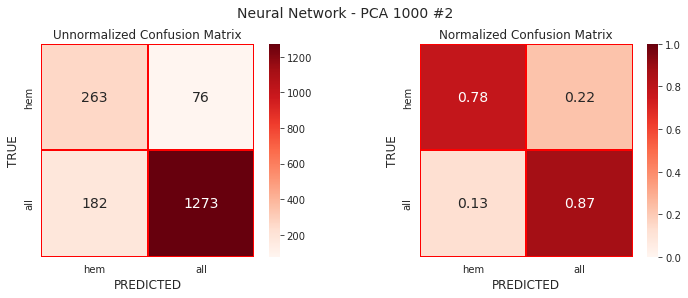

In [165]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network - PCA 1000 #2', y_test, y_pred_pca2, target_names, 'Reds')

In [166]:
print(classification_report(y_test, y_pred_pca2, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.59      0.78      0.67       339
         all       0.94      0.87      0.91      1455

    accuracy                           0.86      1794
   macro avg       0.77      0.83      0.79      1794
weighted avg       0.88      0.86      0.86      1794



#### Save the model

In [151]:
save_piped_model(nn_pca_2, 'nn_pca_2', 'clf', './saved_models/batch_4_stack' )

#### Test loading the model

In [152]:
model_l = load_piped_model('nn_pca_2', 'clf', './saved_models/batch_4_stack' )

In [153]:
# Make predictions with the hypertuned model
y_pred = model_l.predict(X_test)

In [154]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 85.62


In [155]:
# Compare training and testing scores
print(f"Training Data Score: {model_l.score(X_train, y_train)}")
print(f"Testing Data Score: {model_l.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8561872909698997


 ## Model nn_pca_3

In [179]:
params = {'clf__epochs': 80,
 'clf__batch_size': 128,
 'clf__model__dropout': 0.5214000000000001,
 'clf__optimizer__learning_rate': 0.0012108737025966388,
 'clf__model__hidden_layer_sizes': (250,)}

In [180]:
pipe.set_params(**params)
    ## model = SVC(**params, kernel='linear', random_state=random_state)
nn_pca_3 = pipe.fit(X_train, y_train)

In [181]:
nn_pca_3

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=1000, random_state=10)),
                ('clf',
                 KerasClassifier(batch_size=128, epochs=80, loss='binary_crossentropy', model=<function get_clf at 0x7fec4a2bfbe0>, model__dropout=0.5214000000000001, model__hidden_layer_sizes=(250,), optimizer='adam', optimizer__learning_rate=0.0012108737025966388, random_state=10, verbose=0))])

In [182]:
# Make predictions with the hypertuned model
y_pred_pca3 = nn_pca_3.predict(X_test)

In [183]:
accuracy = accuracy_score(y_test, y_pred_pca3)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 86.90


In [184]:
# Compare training and testing scores
print(f"Training Data Score: {nn_pca_3.score(X_train, y_train)}")
print(f"Testing Data Score: {nn_pca_3.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8690078037904125


In [185]:
cm = confusion_matrix(y_test, y_pred_pca3)
print(cm)

[[ 263   76]
 [ 159 1296]]


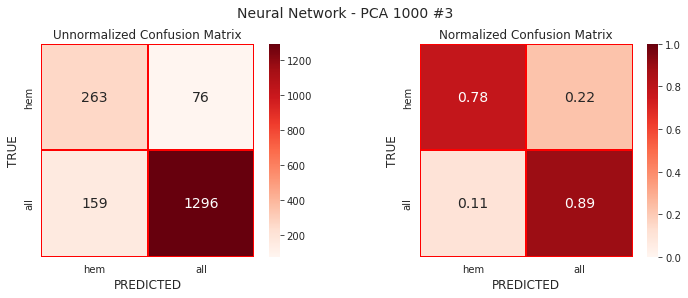

In [186]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network - PCA 1000 #3', y_test, y_pred_pca3, target_names, 'Reds')

In [187]:
print(classification_report(y_test, y_pred_pca3, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.62      0.78      0.69       339
         all       0.94      0.89      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.78      0.83      0.80      1794
weighted avg       0.88      0.87      0.87      1794



#### Save the model

In [188]:
save_piped_model(nn_pca_3, 'nn_pca_3', 'clf', './saved_models/batch_4_stack' )

 ## Model nn_pca_t_2

In [190]:
params = {'pca__n_components': 1044,
 'clf__epochs': 50,
 'clf__batch_size': 128,
 'clf__model__dropout': 0.4064217815350598,
 'clf__optimizer__learning_rate': 0.0014017856089746264,
 'clf__model__hidden_layer_sizes': (140,)}

In [191]:
pipe.set_params(**params)
    ## model = SVC(**params, kernel='linear', random_state=random_state)
nn_pca_t_2 = pipe.fit(X_train, y_train)

In [192]:
nn_pca_t_2

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=1044, random_state=10)),
                ('clf',
                 KerasClassifier(batch_size=128, epochs=50, loss='binary_crossentropy', model=<function get_clf at 0x7fec4a2bfbe0>, model__dropout=0.4064217815350598, model__hidden_layer_sizes=(140,), optimizer='adam', optimizer__learning_rate=0.0014017856089746264, random_state=10, verbose=0))])

In [193]:
# Make predictions with the hypertuned model
y_pred_pcat2 = nn_pca_t_2.predict(X_test)

In [194]:
accuracy = accuracy_score(y_test, y_pred_pcat2)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 85.67


In [195]:
# Compare training and testing scores
print(f"Training Data Score: {nn_pca_t_2.score(X_train, y_train)}")
print(f"Testing Data Score: {nn_pca_t_2.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8567447045707915


In [196]:
cm = confusion_matrix(y_test, y_pred_pcat2)
print(cm)

[[ 255   84]
 [ 173 1282]]


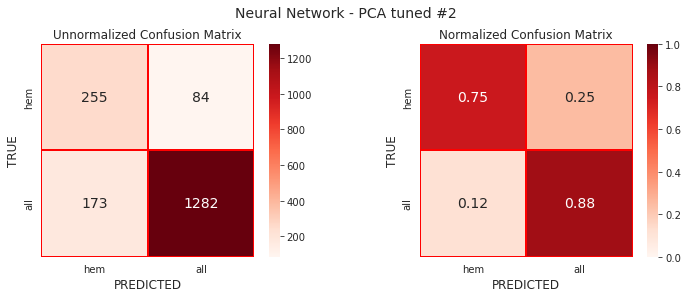

In [199]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network - PCA tuned #2', y_test, y_pred_pcat2, target_names, 'Reds')

In [200]:
print(classification_report(y_test, y_pred_pcat2, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.60      0.75      0.66       339
         all       0.94      0.88      0.91      1455

    accuracy                           0.86      1794
   macro avg       0.77      0.82      0.79      1794
weighted avg       0.87      0.86      0.86      1794



#### Save the model

In [201]:
save_piped_model(nn_pca_t_2, 'nn_pca_t_2', 'clf', './saved_models/batch_4_stack' )

 ## Model nn_pca_t_2a

In [202]:
params = {'pca__n_components': 1056,
 'clf__epochs': 120,
 'clf__batch_size': 128,
 'clf__model__dropout': 0.3068920343908312,
 'clf__optimizer__learning_rate': 0.0021838722078525593,
 'clf__model__hidden_layer_sizes': (260,)}

In [203]:
pipe.set_params(**params)
    ## model = SVC(**params, kernel='linear', random_state=random_state)
nn_pca_t_2a = pipe.fit(X_train, y_train)

In [204]:
nn_pca_t_2a

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=1056, random_state=10)),
                ('clf',
                 KerasClassifier(batch_size=128, epochs=120, loss='binary_crossentropy', model=<function get_clf at 0x7fec4a2bfbe0>, model__dropout=0.3068920343908312, model__hidden_layer_sizes=(260,), optimizer='adam', optimizer__learning_rate=0.0021838722078525593, random_state=10, verbose=0))])

In [205]:
# Make predictions with the hypertuned model
y_pred_pcat2a = nn_pca_t_2a.predict(X_test)

In [206]:
accuracy = accuracy_score(y_test, y_pred_pcat2a)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 86.34


In [207]:
# Compare training and testing scores
print(f"Training Data Score: {nn_pca_t_2a.score(X_train, y_train)}")
print(f"Testing Data Score: {nn_pca_t_2a.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8634336677814939


In [208]:
cm = confusion_matrix(y_test, y_pred_pcat2a)
print(cm)

[[ 256   83]
 [ 162 1293]]


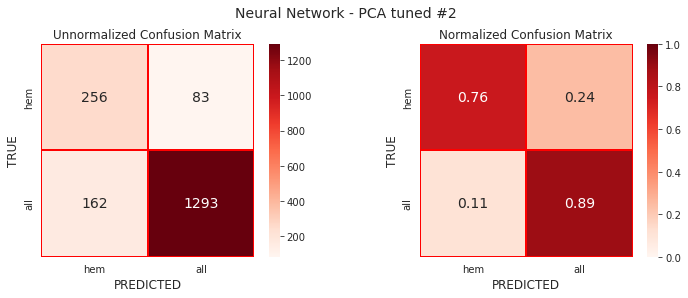

In [209]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Neural Network - PCA tuned #2', y_test, y_pred_pcat2a, target_names, 'Reds')

In [210]:
print(classification_report(y_test, y_pred_pcat2a, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.61      0.76      0.68       339
         all       0.94      0.89      0.91      1455

    accuracy                           0.86      1794
   macro avg       0.78      0.82      0.79      1794
weighted avg       0.88      0.86      0.87      1794



#### Save the model

In [211]:
save_piped_model(nn_pca_t_2a, 'nn_pca_t_2a', 'clf', './saved_models/batch_4_stack' )